#  Image Visualization Basics with Astropy
ds9 is a really powerful tool for working with astronomical images, but for deep analyses and making figures for publication and presentation, we often want to be able to work with images in Python.

In [11]:
# Imports
import numpy as np

from astropy.io import fits
import astropy.visualization as vis
from astropy.wcs import WCS # World Coordinate System handling

# Plotting
import matplotlib.pyplot as plt

# Magically make plots appear in the notebook
%matplotlib inline

# Change this to point to the directory containing the M83 data products
# for today's examples, if you didn't download and unzip them in this directory.
data_path = 'M83/'

## Image I/O and Metadata
Images are binary files by their nature. We normally distribute them in the `.fits` format. We'll use the `astropy.io.fits` interface to load them here.

In [2]:
# These are HDULists once again.
M83_05_2_hdul = fits.open(data_path + 'NGC5236-0p5to2-asca-merged-im-bin1.fits')
M83_2_7_hdul = fits.open(data_path + 'NGC5236-2to7-asca-merged-im-bin1.fits')

For these HDULists (and most monochromatic images), the image is the first entry:

In [3]:
M83_05_2_hdul

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7faea82f34a8>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7faeabd2deb8>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7faeabd37a20>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7faeabd3c550>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7faeabd37898>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7faeabd2dda0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7faeabd410f0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7faeabd41be0>]

In this specific case, most of the other extensions are GTI (good time interval) tables from the individual observations co-added to make the final image. We'll put the headers and images into variables for later reference, and display the top of the header for the SB image.

In [5]:
M83_05_2_hdr = M83_05_2_hdul[0].header
M83_05_2_img = M83_05_2_hdul[0].data

M83_2_7_hdr = M83_2_7_hdul[0].header
M83_2_7_img = M83_2_7_hdul[0].data

M83_05_2_hdr[:9]

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 2000 / length of data axis                            
NAXIS2  =                 2000 / length of data axis                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
HDUNAME = 'EVENTS_IMAGE'       / ASCDM block name                               

The `NAXIS` keywords here tell us that the image is 2D, and that it has 2000 columns and 2000 rows. The `BITPIX` keyword also tells us that each pixel is a 16 bit number; in this case an integer.

There's a ton of other information in the header, but unfortunately a lot of the automated pipelines used to make co-added images from many observations make headers basically illegible. Fortunately, they're still machine-readable. What we need to extract is the information describing the World Coordinate System (WCS), the transformation between pixel coordinates (x,y) and sky coordinates (RA, Dec). This consists, basically, of the sky coordinates of a specific reference pixel, and the Jacobian matrix describing how the sky coordinates vary with x and y.

Astropy contains a class, `astropy.wcs.WCS` that holds all this information and can pull the required information out of the header, which will work in most situations, as long as the images were created according to the WCS standards:

In [16]:
wcs_05_2 = WCS(M83_05_2_hdr)
wcs_2_7 = WCS(M83_2_7_hdr)

Let's look at what's in here, for the 0.5-2.0 keV image (the WCS information for both images is actually the same, note that this is not guaranteed nor should it be expected when dealing with, for example images of the same object from different instruments).

In [17]:
wcs_05_2

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 204.262507971  -29.8552317409  
CRPIX : 929.0  1092.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00013666666666667  0.00013666666666667  
NAXIS : 2000  2000

The number of WCS axes is 2, as we might expect; the next line tells us that these axes are RA and Dec, also as we might expect. The next two lines, `CRVAL` and `CRPIX` tell us the sky coordinates and pixel coordinates of the reference pixel. The lines starting with `PC` give us the correlation matrix of the pixel and sky coordinates. It's diagonal, so that tells us that the image has already been reprojected such that x corresponds to right ascension (East-West) and y corresponds to declination (North-South). This is nice, but again not guaranteed. The last bit of new information here is `CDELT`: it's telling us how many degrees of RA and Dec correspond to moving 1 pixel in x and y. Here, 1 pixel left is a $0.0001367^\circ$ ($0.492''$) *increase* in RA, while 1 pixel up increases the declination by the same value. This is the pixel scale (occasionally called plate scale) of the image.

## Displaying images
Pyplot has a builtin tool for displaying images, but the default settings aren't great for our purposes most of the time:

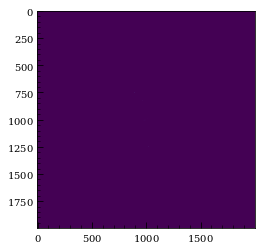

In [19]:
fig, ax = plt.subplots()

ax.imshow(M83_05_2_img)

That's ... not very informative. The primary issues here are normalization and contrast. To display an image, matplotlib must map the data units to brightness values from 0 to 1. By default, it does this by mapping the lowest value is mapped to 0, the brightest value to 1, and assuming a linear scale in brightness between. This will work in some cases, but in a lot of astronomical images we have a ton of contrast, so we end up needing to change this mapping to emphasize faint features in the image. In this particular image we're looking at some soft X-ray emission from the ISM in M87, so we'll want to get this right in order to see that faint, extended emission.

Astropy has a way to do this pretty easily, with the `astropy.visualization.simple_norm()` function. We can think of this function as automating two steps for us:
1. "Clipping" the range or scale of the data, by discarding some values that are higher than or lower than a prescribed value
2. "Stretching" the clipped data by defining the function used to map it to [0,1]

Let's try using it a few different ways:

Text(0.5, 1.0, 'sqrt stretch, 99% scale')

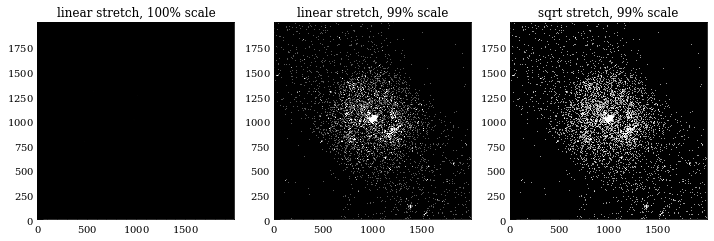

In [28]:
fig, axs = plt.subplots(1,3, figsize=(12,4))

norm1 = vis.simple_norm(M83_05_2_img, stretch='linear') # This is the same as before
norm2 = vis.simple_norm(M83_05_2_img, percent=99.0, stretch='linear')
norm3 = vis.simple_norm(M83_05_2_img, percent=99.0, stretch='sqrt')

# Before the image was using a purple-yellow color map that's the matplotlib default;
# here I'm switching to grayscale.
# Also, note that before the "origin" (0,0) point of the image was in the top left; that's
# conventional for most computer graphics but not astronomical images. We can change to what we
# expect by setting `origin='lower'` in the imshow command:


axs[0].imshow(M83_05_2_img, norm=norm1, cmap='gray', origin='lower')
axs[1].imshow(M83_05_2_img, norm=norm2, cmap='gray', origin='lower')
axs[2].imshow(M83_05_2_img, norm=norm3, cmap='gray', origin='lower')

axs[0].set_title('linear stretch, 100% scale')
axs[1].set_title('linear stretch, 99% scale')
axs[2].set_title('sqrt stretch, 99% scale')

The "percent" command that I'm using above is one way of defining the max and min (1 and 0) brightness of the resulting image: imagine histogramming the pixel values and setting the minimum brightness to the 0.5th percentile and the maximum to the 99.5th, so that you have 99% of the pixel values inside that range.

We can also define our maximum and minimum brightness manually:

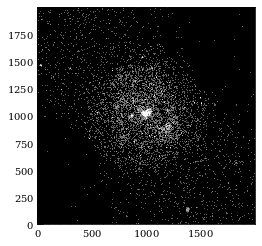

In [38]:
fig, ax = plt.subplots(figsize=(4,4))

# Anything above 7 counts is set to max brightness, and the final brightness is
# proportional to the square root of the pixel value
norm = vis.simple_norm(M83_05_2_img, stretch='sqrt', min_cut=0, max_cut=7)

ax.imshow(M83_05_2_img, norm=norm, cmap='gray', origin='lower')

Different scales and stretches work better for different kinds of images; often if you need to put an image in a figure it's a good idea to play around with an image in ds9 first to find out what sort of scale looks good. Often, we might also want to smooth the image before displaying it, especially if the goal is to emphasize extended emission. But, that's a whole thing, and we might cover it later if necessary.

### Displaying images with WCS projection
From the tick marks on the plots above you might have noticed that matplotlib is displaying the pixel coordinates of the images. A lot of the time if you're just working with an image this is OK, but often, and especially if you're making a figure for a paper you might want the axes to correspond to the sky coordinates. This is also relatively simple to do, and in fact we've already done all the necessary work, when we created WCS objects for our images up above. We need to define our axes in a different way, but the trick is to set the "projection" keyword when do so:

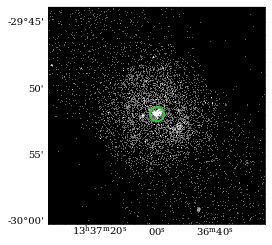

In [57]:
# My habit is normally to use plt.subplots() to define the figure and the axes together,
# but the astropy WCS Axes interface doesn't like that. It's easy to work around though;
# see the link in 'further reading' for a couple of other, equivalent ways of doing it.
fig = plt.figure()
ax = fig.add_subplot(projection=wcs_05_2)

norm = vis.simple_norm(M83_05_2_img, stretch='sqrt', min_cut=0, max_cut=7)

ax.imshow(M83_05_2_img, norm=norm, cmap='gray', origin='lower')

# We can now also overplot things in world coordinates using the 'transform' keyword of the base
# matplotlib plotting functions. The method ax.get_transform('world') returns a function that converts
# pixel to world coordinates, which we then pass as the 'transform' keyword. Annoyingly, the size keyword 's'
# is not affected by the transform, so we can't just specify the size of a marker in, say, degrees
# when we're using the scatter function.

ax.scatter(204.2503, -29.866, transform=ax.get_transform('world'),
           marker='o',
           s=200,
           edgecolor='limegreen',
           facecolor='none',
           linewidth=2.0)

## Further Reading
- Fits I/O: https://docs.astropy.org/en/stable/io/fits/index.html
- Pyplot imshow: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
- Image normalization: https://docs.astropy.org/en/stable/visualization/normalization.html
- WCS Axes: https://docs.astropy.org/en/stable/visualization/wcsaxes/index.html
- All the ways to make WCS axes: https://docs.astropy.org/en/stable/visualization/wcsaxes/initializing_axes.html
- Plotting other stuff on WCS axes: https://docs.astropy.org/en/stable/visualization/wcsaxes/overlays.html